<h1>Inisiasi lokasi dataset dan lokasi keypoint</h1>

In [1]:
yoga_train_images_dir = 'dataset/train'
keypoint_outputs_dir = './keypoints/'

<h1>Generate pose keypoints dari gambar di dataset</h1>

In [2]:
import cv2
import numpy as np
import os
import tqdm
import matplotlib.pyplot as plt
from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose

In [3]:
pose_class_names = sorted([n for n in os.listdir(yoga_train_images_dir)])

for pose_class_name in pose_class_names:
    image_names = sorted([n for n in os.listdir(os.path.join(yoga_train_images_dir, pose_class_name))])
    
    try:
        os.makedirs(os.path.join(keypoint_outputs_dir, pose_class_name))
    except:
        break
    
    print("Bootstrapping", pose_class_name)
    for image_name in tqdm.tqdm(image_names):
        input_frame = cv2.imread(os.path.join(yoga_train_images_dir, pose_class_name, image_name))
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        
        with mp_pose.Pose() as pose_tracker:
            result = pose_tracker.process(image=input_frame)
            pose_landmarks = result.pose_landmarks
        
        output_frame = input_frame.copy()
        mp_drawing.draw_landmarks(image=output_frame, landmark_list=pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
        
        output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
        # cv2.imwrite(os.path.join(train_outputs_dir, image_name), output_frame)
        
        if pose_landmarks is not None: 
            pose_landmarks = [[landmark.x, landmark.y, landmark.z] for landmark in pose_landmarks.landmark]
            frame_height, frame_width = output_frame.shape[:2]
            
            # question: does de-normalizing keypoint coordinates affect training? Later, try training network using [0,1] normalization of coordinates instead of absolute
            pose_landmarks *= np.array([frame_height, frame_height, frame_width])
            
            pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(np.float32).tolist()
            
            npy_savepath = os.path.join(keypoint_outputs_dir, pose_class_name, image_name[0:-4]) # remove any .jpg, .png, etc suffix
            np.save(npy_savepath, pose_landmarks)


Bootstrapping Downdog


100%|██████████| 223/223 [01:00<00:00,  3.70it/s]


Bootstrapping Goddess


100%|██████████| 180/180 [00:46<00:00,  3.91it/s]


Bootstrapping Plank


100%|██████████| 266/266 [01:07<00:00,  3.93it/s]


Bootstrapping Tree


100%|██████████| 160/160 [00:43<00:00,  3.68it/s]


Bootstrapping Warrior2


100%|██████████| 252/252 [01:03<00:00,  3.96it/s]


<h1>Generate train/test datasets</h1>

In [4]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from glob import glob

In [5]:
label_map = {label:num for num,label in enumerate(pose_class_names)}
print(label_map)

{'Downdog': 0, 'Goddess': 1, 'Plank': 2, 'Tree': 3, 'Warrior2': 4}


In [6]:
sequences, labels = [], []

for pose_class_name in pose_class_names:
    keypoint_names = glob(os.path.join(keypoint_outputs_dir, pose_class_name, "*.npy"))
    
    print("searching through {}".format(pose_class_name))
    for keypoint_name in tqdm.tqdm(keypoint_names):
        file = np.load(keypoint_name)
        sequences.append(file)
        labels.append(label_map[pose_class_name])
    

searching through Downdog


100%|██████████| 199/199 [00:00<00:00, 1706.96it/s]


searching through Goddess


100%|██████████| 172/172 [00:00<00:00, 1793.14it/s]


searching through Plank


100%|██████████| 263/263 [00:00<00:00, 1652.44it/s]


searching through Tree


100%|██████████| 159/159 [00:00<00:00, 3943.55it/s]


searching through Warrior2


100%|██████████| 249/249 [00:00<00:00, 5145.45it/s]


In [7]:
print(len(sequences))
print(len(labels))

print(np.array(sequences).shape)
print(np.array(labels).shape)

1042
1042
(1042, 99)
(1042,)


In [8]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(y.shape)

(1042, 5)


5% split for test save ke model

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.05)

In [10]:
print(X_train.shape)
print(len(X_test))

(989, 99)
53


<h1>Generate model</h1>

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer, Dropout

In [12]:
model = Sequential([
    InputLayer(input_shape=(99,)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

In [13]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3200      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 14277 (55.77 KB)
Trainable params: 14277 (55.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<h1>Training</h1>

Epoch 1/150


31/31 [==============================] - 1s 2ms/step - loss: 28.5795 - categorical_accuracy: 0.4752
Epoch 2/150
31/31 [==============================] - 0s 2ms/step - loss: 4.5785 - categorical_accuracy: 0.7017
Epoch 3/150
31/31 [==============================] - 0s 2ms/step - loss: 2.9897 - categorical_accuracy: 0.7897
Epoch 4/150
31/31 [==============================] - 0s 2ms/step - loss: 1.6905 - categorical_accuracy: 0.8362
Epoch 5/150
31/31 [==============================] - 0s 2ms/step - loss: 1.0908 - categorical_accuracy: 0.8615
Epoch 6/150
31/31 [==============================] - 0s 2ms/step - loss: 0.8758 - categorical_accuracy: 0.8716
Epoch 7/150
31/31 [==============================] - 0s 2ms/step - loss: 0.8674 - categorical_accuracy: 0.8797
Epoch 8/150
31/31 [==============================] - 0s 2ms/step - loss: 0.6076 - categorical_accuracy: 0.8938
Epoch 9/150
31/31 [==============================] - 0s 2ms/step - loss: 0.4485 - categorical_accuracy: 0.914

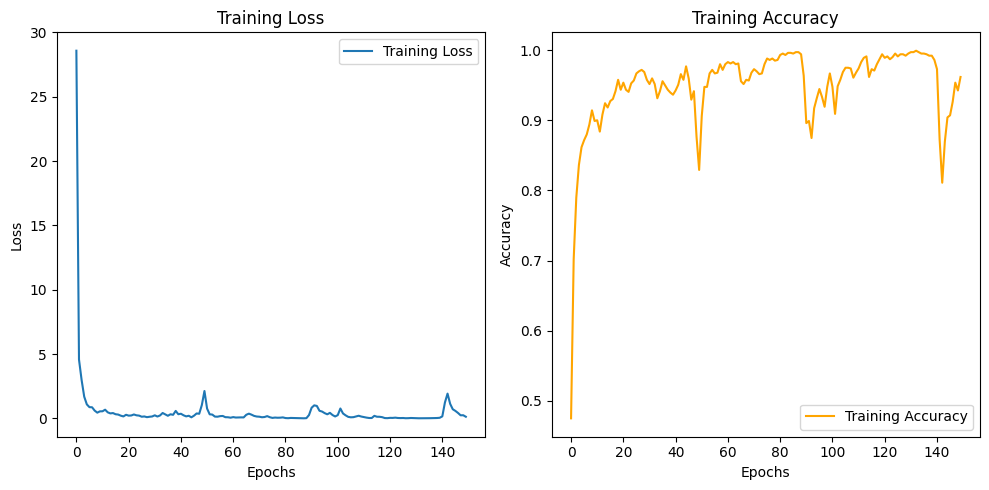

In [14]:
# Contoh kode pelatihan model
history = model.fit(X_train, Y_train, epochs=150)

# Menampilkan grafik loss dan akurasi dalam satu grafik
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan grafik
plt.tight_layout()
plt.show()

#model.fit(X_train, Y_train, epochs=150)

<h1>Prediksi</h1>

In [15]:
poses_mapping = {0: 'Downdog', 1: 'Goddess', 2: 'Plank', 3: 'Tree', 4: 'Warrior2'}

2/2 [==============================] - 0s 4ms/step


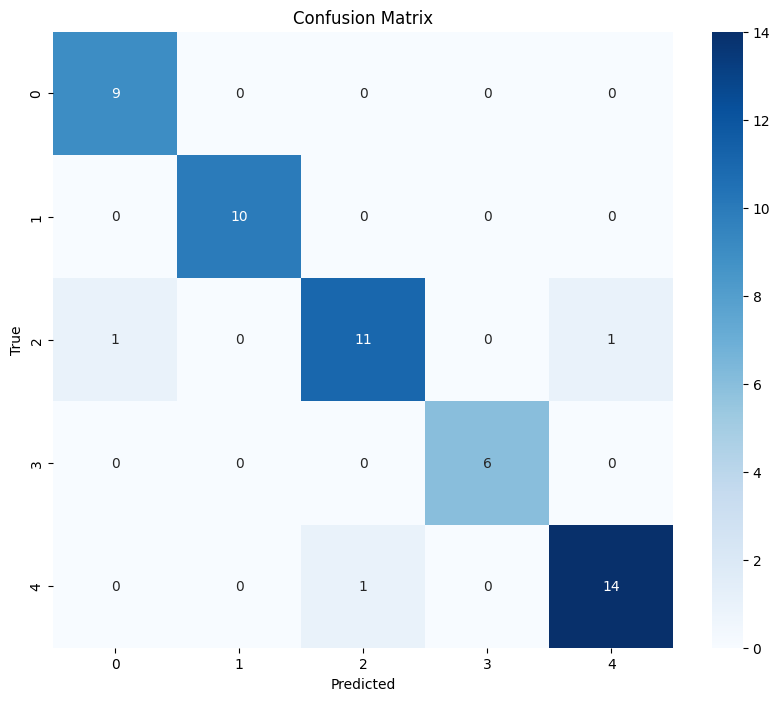

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prediksi kelas untuk data uji
Y_pred = model.predict(X_test)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Mendapatkan matriks kebingungan
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Menampilkan matriks kebingungan dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=poses_mapping, yticklabels=poses_mapping)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
poses_label = ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']
from sklearn.metrics import classification_report
classification_rep = classification_report(y_true, y_pred_classes, target_names=poses_label)
print(classification_rep)

              precision    recall  f1-score   support

     Downdog       0.90      1.00      0.95         9
     Goddess       1.00      1.00      1.00        10
       Plank       0.92      0.85      0.88        13
        Tree       1.00      1.00      1.00         6
    Warrior2       0.93      0.93      0.93        15

    accuracy                           0.94        53
   macro avg       0.95      0.96      0.95        53
weighted avg       0.94      0.94      0.94        53



In [18]:
poses_mapping = {0: 'Downdog', 1: 'Goddess', 2: 'Plank', 3: 'Tree', 4: 'Warrior2'}
result = model.predict(X_test)

print("Predicted pose:", poses_mapping[np.argmax(result[0])])
print("Actual pose:", poses_mapping[np.argmax(Y_test[0])])

2/2 [==============================] - 0s 3ms/step
Predicted pose: Warrior2
Actual pose: Warrior2


<h3>Save model</h3>

In [19]:
model.save('./model_save/model.h5')

c:\Users\Farhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
